In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

## Hyperparameters and Constants

Here, we define wether to train the model or not and for how many epochs to train for.

If `TRAIN = False`, then the last trained model will be used for inference in the notebook if run end to end.

In [2]:
TRAIN = False
# Number of epochs to train for.
EPOCHS = 25

# Prepare Dataset

In [9]:
!gdown 1pjc4udB3nFkcmQhSgHge4hRxyRBXlyPr

Downloading...
From (uriginal): https://drive.google.com/uc?id=1pjc4udB3nFkcmQhSgHge4hRxyRBXlyPr
From (redirected): https://drive.google.com/uc?id=1pjc4udB3nFkcmQhSgHge4hRxyRBXlyPr&confirm=t&uuid=9003b8a9-ebc3-45a5-94ed-a8a416ee012c
To: /home/harsha/Desktop/ipsita/data.zip
100%|██████████████████████████████████████| 5.16G/5.16G [01:19<00:00, 64.9MB/s]


In [ ]:
!unzip data.zip

## Helper Functions to Download Files

The following function is for downloading any file in the notebook. In further sections of the notebook, we will use it for downloading the inference data.

In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
    else: 
        print('File already present, skipping download...')

### Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images. 

The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format.

In [3]:
class_names = ['motorbike', 'DHelmet', 'DNoHelmet', 'P1Helmet', 'P1NoHelmet', 'P2Helmet', 'P2NoHelmet']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    print(bboxes)
    left = bboxes[0]
    top = bboxes[1]
    width = bboxes[2]
    height = bboxes[1]
    xmin, ymin = left, top # top left of BB
    xmax, ymax = left+width, top+width # bottom right of BB
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines() 
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
                print(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    # plt.show()

In [ ]:
# Visualize a few training images.
# plot(
#     image_paths='train/images/1_1.jpg',
#     label_paths='train/labels/1_1.txt',
#     num_samples=1,
# )

## Helper Functions for Logging

Here, we write the helper functions that we need for logging of the results in the notebook while training the models.

Let's create our custom result directories so that we can easily keep track of them and carry out inference using the proper model.

In [8]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

**Function to Monitor TensorBoard logs**.

In [5]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

## Clone YOLOV5 Repository

In [6]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15543, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 15543 (delta 60), reused 92 (delta 43), pack-reused 15393
Receiving objects: 100% (15543/15543), 14.59 MiB | 48.66 MiB/s, done.
Resolving deltas: 100% (10588/10588), done.


In [13]:
%cd yolov5/
!pwd

/home/harsha/Desktop/ipsita/yolov5
/home/harsha/Desktop/ipsita/yolov5


In [8]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 2.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.9/757.9 kB 11.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 21.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 40.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 28.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 902.7 kB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 42.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 579.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Training using YOLOV5

The next step is to train the neural network model.

### Train a Small (yolov5s) Model

Training all the layers of the small model.

In [ ]:
# monitor_tensorboard()

In [9]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5s.pt --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 0


## Check Out the Validation Predictions and Inference

In this section, we will check out the predictions of the validation images saved during training. Along with that, we will also check out inference of images and videos.

### Visualization and Inference Utilities

We will visualize the validation prediction images that are saved during training. The following is the function for that.

In [3]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

The following functions are for carrying out inference on images and videos.

In [4]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

We may also need to visualize images in any of the directories. The following function accepts a directory path and plots all the images in them. 

In [5]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

**Visualize validation prediction images.**

confusion_matrix.png	PR_curve.png	  val_batch0_labels.jpg
F1_curve.png		R_curve.png	  val_batch0_pred.jpg
hyp.yaml		results.csv	  val_batch1_labels.jpg
labels_correlogram.jpg	results.png	  val_batch1_pred.jpg
labels.jpg		train_batch0.jpg  val_batch2_labels.jpg
opt.yaml		train_batch1.jpg  val_batch2_pred.jpg
P_curve.png		train_batch2.jpg  weights
['runs/train/results_1/val_batch0_pred.jpg', 'runs/train/results_1/val_batch1_pred.jpg', 'runs/train/results_1/val_batch2_pred.jpg']


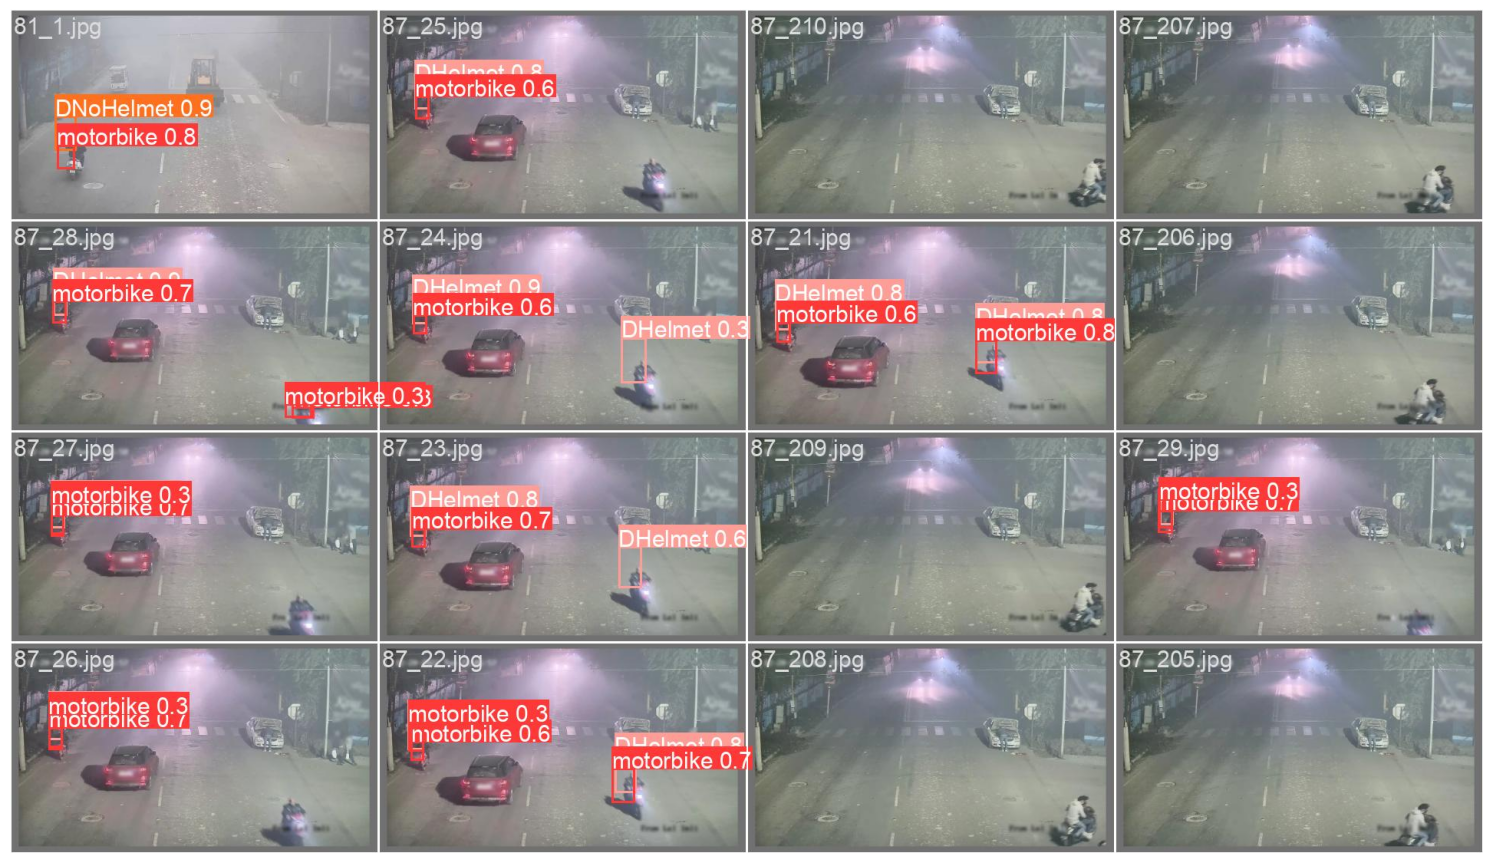

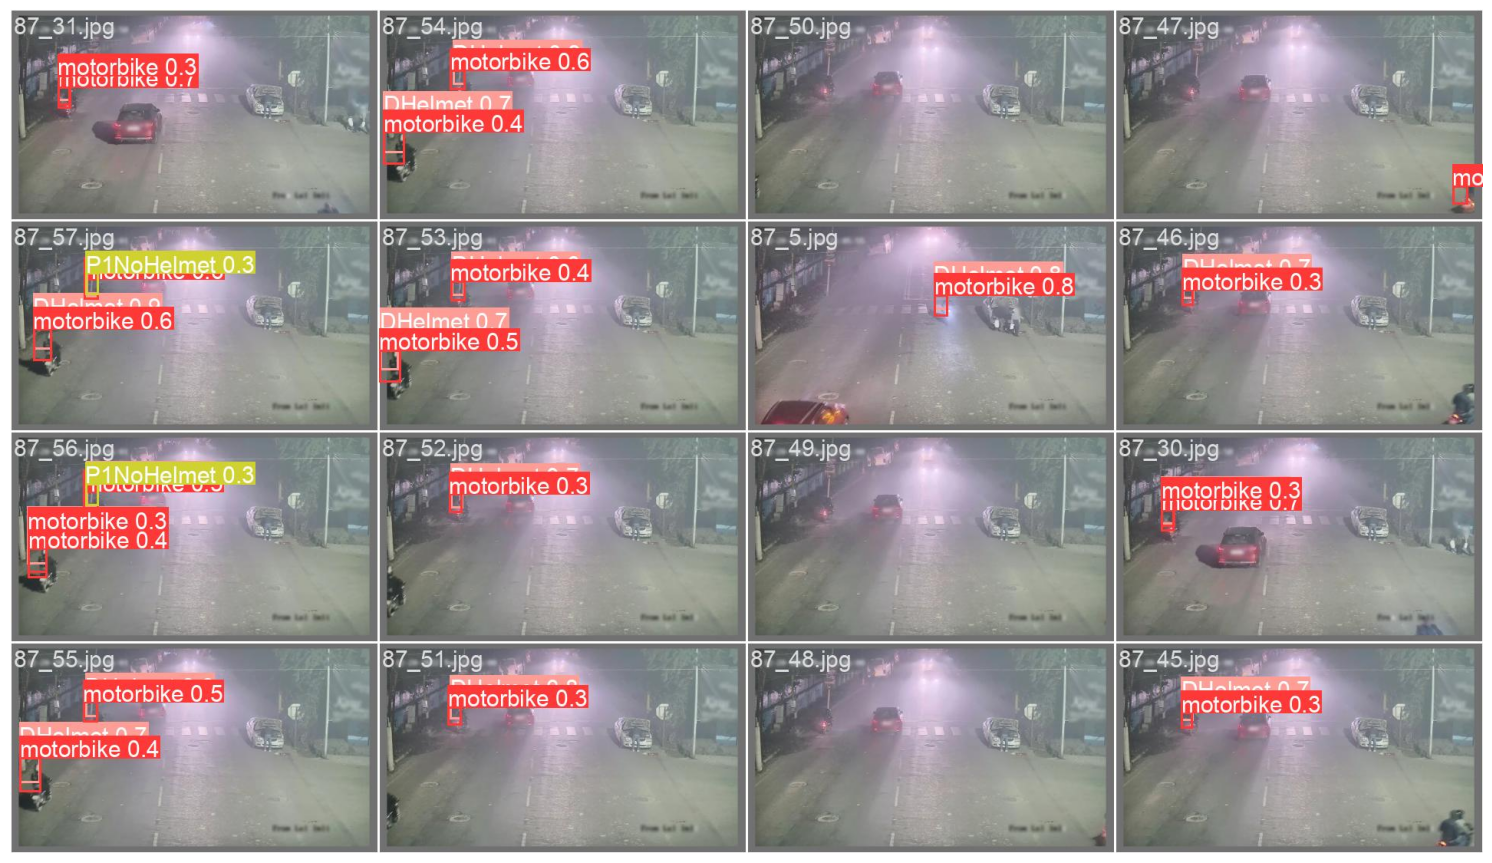

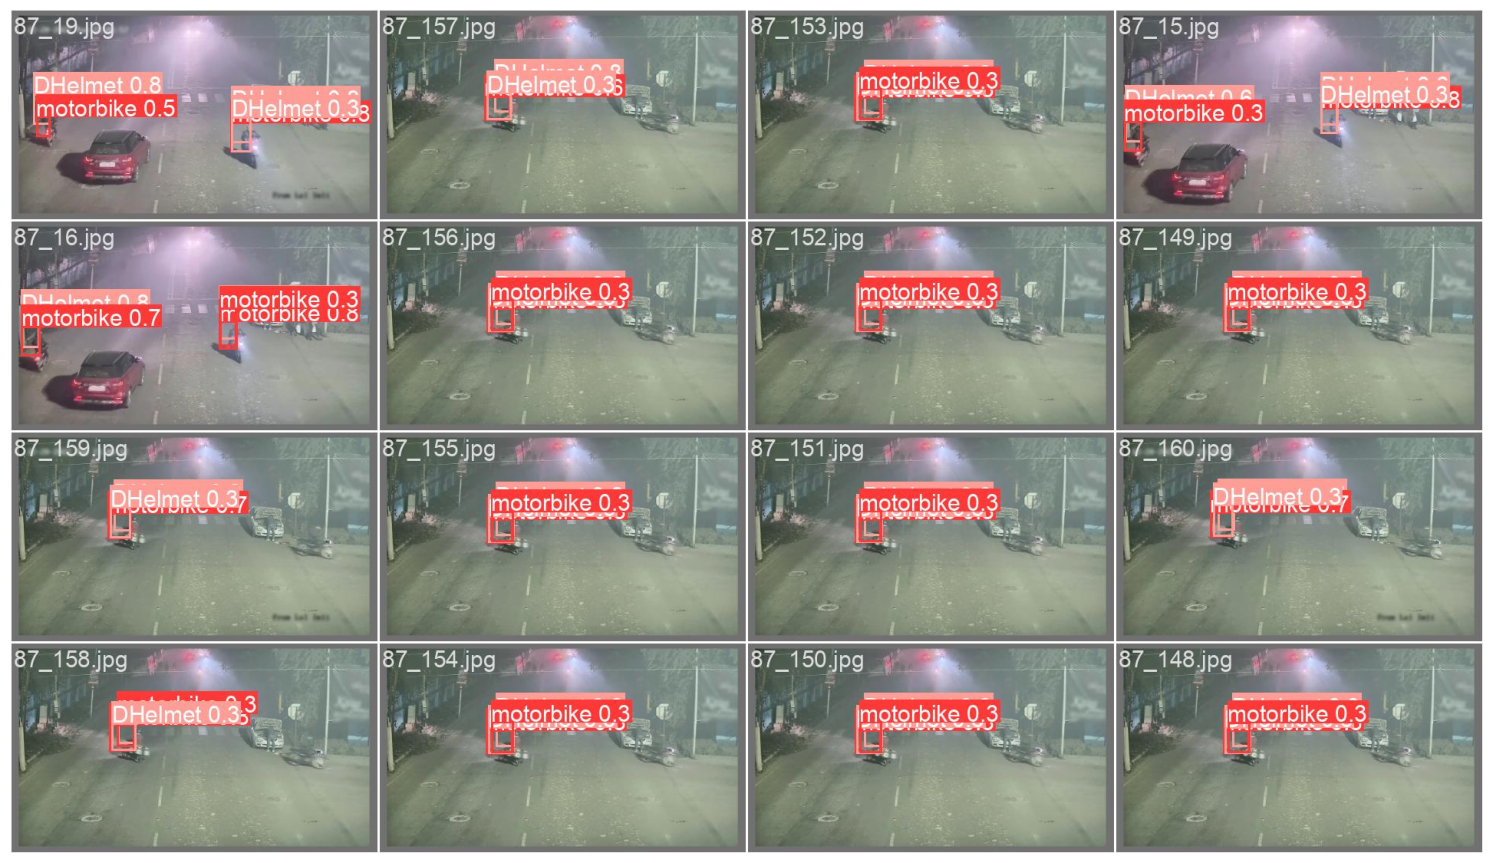

In [17]:

show_valid_results(RES_DIR)

### Inference
In this section, we will carry out inference on unseen videos in the test folder. 

**To carry out inference on images, we just need to provide the directory path where all the images are stored, and inference will happen on all images automatically.**

### Inference on Videos

In [21]:
inference(RES_DIR, '../test/images')

Current number of inference detection directories: 1
inference_2
detect: weights=['runs/train/results_1/weights/best.pt'], source=../test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=inference_2, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /home/harsha/Desktop/ipsita/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.11.3 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11175MiB)

Fusing layers... 
Model summary: 157 layers, 7029004 parameters, 0 gradients, 15.8 GFLOPs
video 1/10 (1/199) /home/harsha/Desktop/ipsita/test/images/091.mp4: 384x640 (no detections), 21.4ms
video 1/10 (2/199) /home/harsha/Desktop/ipsita/test/images/091.mp4: 384

'inference_2'

In [24]:
!python val.py --data ../data.yaml --weights runs/train/{res}/weights/best.pt


val: data=../data.yaml, weights=['runs/train/results_1/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
requirements: /home/harsha/Desktop/ipsita/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.11.3 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11175MiB)

Fusing layers... 
Model summary: 157 layers, 7029004 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /home/harsha/Desktop/ipsita/valid/labels.cache... 1499 images, 556
                 Class     Images  Instances          P          R      mAP50   
                   all       2055       5322      0.632      0.554       0.57      0.307
             motorbike       2055       2586      0.784      0.726      0.779      0.413
               DHelme